<a href="https://colab.research.google.com/github/srihitha-05/Machine-Learning/blob/main/LAB3_AP23110010120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [ ]:
!pip install -q statsmodels==0.14.2

In [ ]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer # fills missing values
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder # Adjusting feature ranges
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer #create new features by combining existing ones, make data more like normal distribution
from sklearn.decomposition import PCA #dimensional reduction
from sklearn.metrics import mean_squared_error #how far ur predictions are diff from actual values

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [ ]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [ ]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [ ]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [ ]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [ ]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist() #selects numeric col and converts into a list
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3) #for each missing value look at 3 nearest neighbors and fill the value with their avg
knn_imputed = imputer.fit_transform(knn_df) # return np array
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

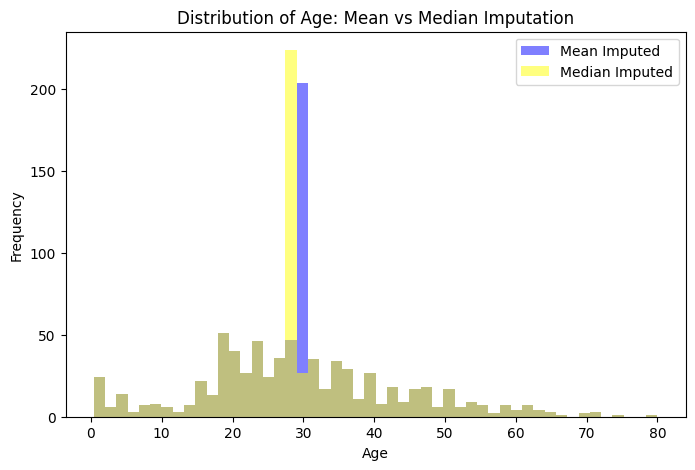

In [ ]:
df_mean = df.copy()
df_median=df.copy()
# Numeric (Age): mean
mean_imputer = SimpleImputer(strategy='mean')
df_mean['Age'] = mean_imputer.fit_transform(df[['Age']])

#median
median_imputer = SimpleImputer(strategy='median')
df_median['Age'] = median_imputer.fit_transform(df[['Age']])

plt.figure(figsize=(8,5))
# plt.hist(df['Age'].dropna(), bins=30, alpha=0.5, label="Original", color="blue")
plt.hist(df_mean['Age'], bins=50, alpha=0.5, label="Mean Imputed", color="blue")
plt.hist(df_median['Age'], bins=50, alpha=0.5, label="Median Imputed", color="yellow")
plt.legend()
plt.title("Distribution of Age: Mean vs Median Imputation")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# fig, axes=plt.subplot(1,2,figsize=(10,4))
# axes[0].hist(df['Age'].dropna(),bins=30)


since the graph is slightly right-skewed, i would say that the median preserves the original distribution better.

In [ ]:
# Original value counts (with NaN included)
print(df['Embarked'].value_counts(dropna=False))

# Option 1: Fill missing with 'Unknown'
embarked_unknown = df['Embarked'].fillna('Unknown')
print(embarked_unknown.value_counts())

# Option 2: Fill missing with mode
mode_value = df['Embarked'].mode()[0]   # usually 'S'
embarked_mode = df['Embarked'].fillna(mode_value)
print(embarked_mode.value_counts())


Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


Unknown:- keeps missingness explicit by adding a new category
Mode:- adds the nan values in to 'S' class as it is the majority class

## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

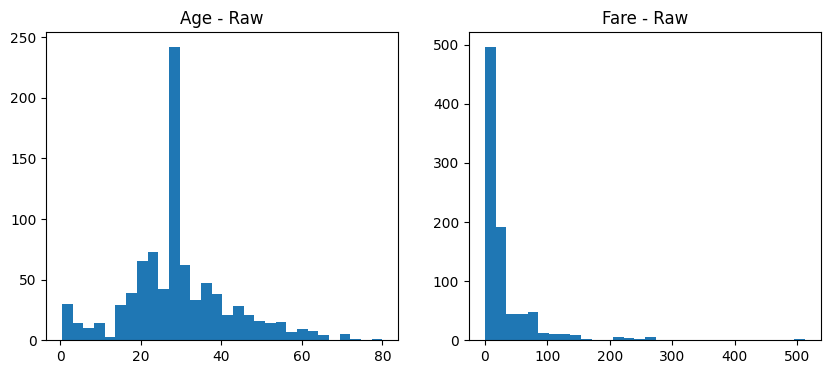

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

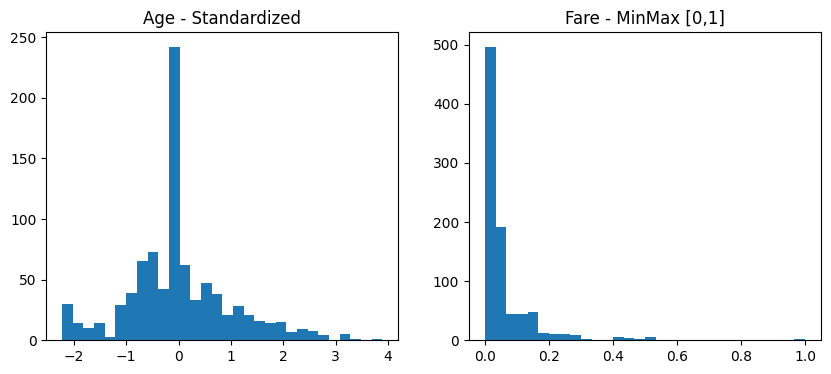

In [ ]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

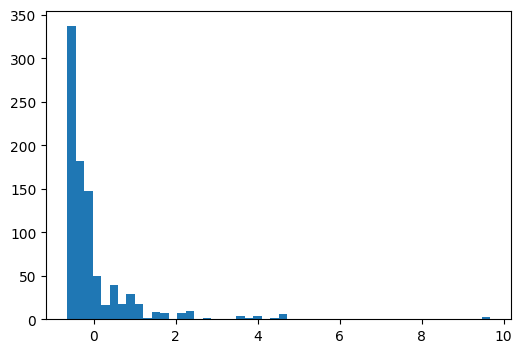

In [ ]:
std=StandardScaler()

fare_std=std.fit_transform(df_imp[['Fare']])

plt.figure(figsize=(6,4))
plt.hist(fare_std.flatten(), bins=50)
plt.show()

In [ ]:
nom=Normalizer()
af_norm= nom.fit_transform(df_imp[['Age','Fare']])
print(af_norm[:5])
# af_norm[['Age','Fare']].head()

[[0.94975704 0.31298812]
 [0.47041706 0.88244422]
 [0.95655127 0.29156418]
 [0.55033828 0.83494178]
 [0.97455519 0.22414769]]


## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [ ]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [ ]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

4.1) Ordinal Encoding:

  *   Assigns one int per column
  *   for Embarked(3 categories: C,Q,S)->1 col only

  One-Hot Encoding:
  *   Creates one binary column per category.
  *   For Embarked → 3 columns (Embarked_C, Embarked_Q, Embarked_S).


2) Linear models (e.g., Linear Regression, Logistic Regression) interpret numeric values as having magnitude and order. Each category is represented independently with 0 or 1, so no false numeric ordering is implied. Model treats them as separate binary variables, preventing bias due to assumed order.

  

## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

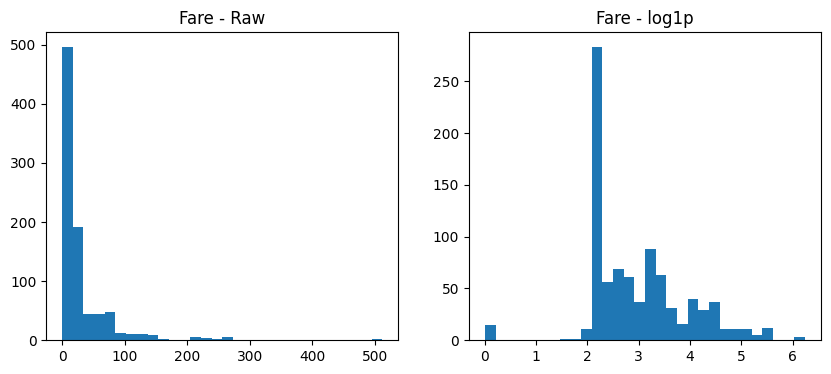

In [ ]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

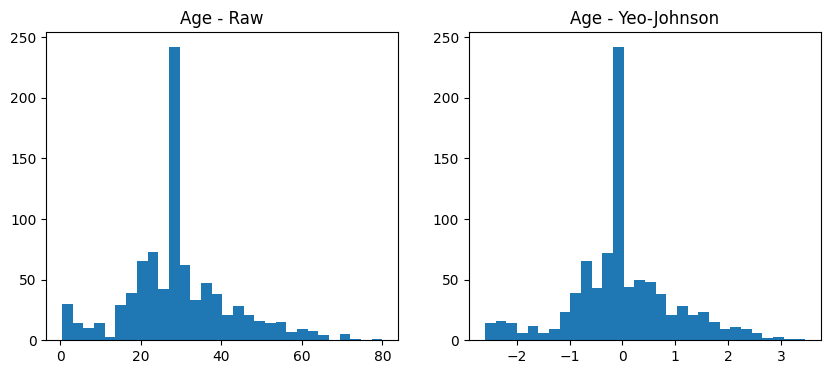

In [ ]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [ ]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

1) Skewed column is Fare



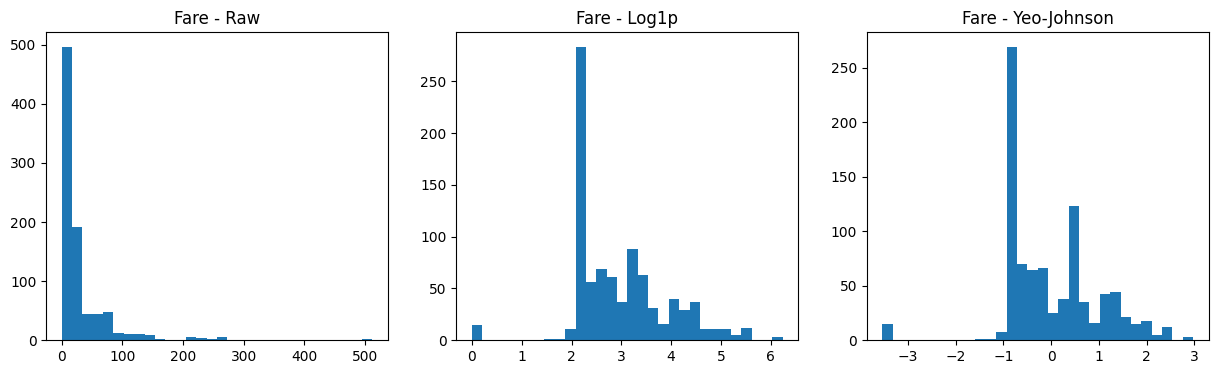

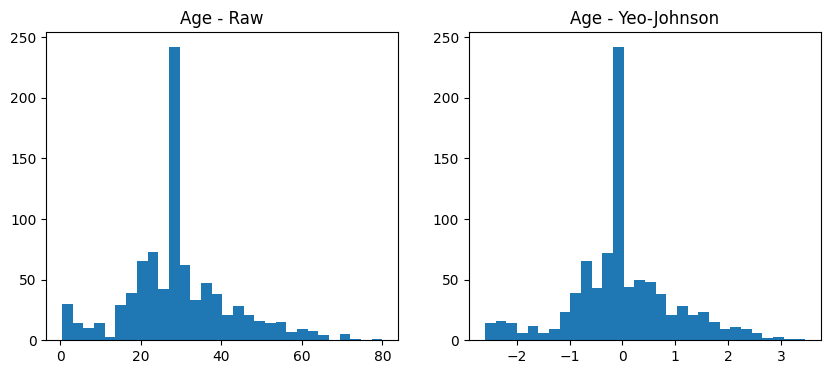

In [ ]:
# --- Log transform (only for positive values) ---
fare_log = np.log1p(af['Fare'].values.reshape(-1,1))

# --- Power transform (Yeo-Johnson) ---
pt = PowerTransformer(method='yeo-johnson')
af_pt = pt.fit_transform(af)

# --- Plot comparison for Fare ---
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].hist(af['Fare'], bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - Log1p')
axes[2].hist(af_pt[:,1], bins=30)
axes[2].set_title('Fare - Yeo-Johnson')
plt.show()

# --- Plot comparison for Age ---
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'], bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()


2) New terms created are Age, Fare, Age^2, Age*Fare, Fare^2

## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96165195 0.03587775]


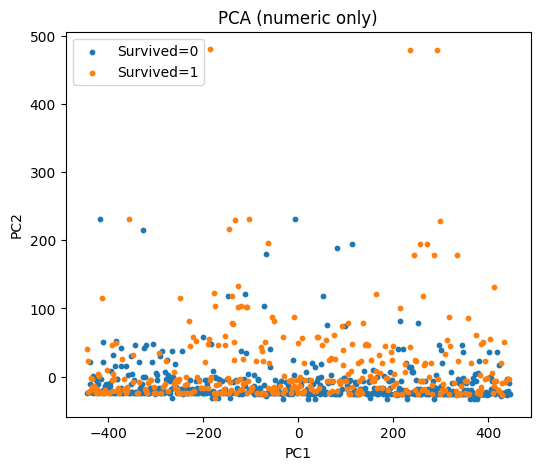

In [ ]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [ ]:
# Compute variance for numeric columns
num_var = df_imp.select_dtypes(include=['number']).var()

# Sort descending
num_var_sorted = num_var.sort_values(ascending=False)
print("Variance per numeric column:\n", num_var_sorted)

# Top 2 columns contributing most variance
top2_cols = num_var_sorted.index[:2]
print("Top 2 columns by variance:", top2_cols.tolist())


Variance per numeric column:
 PassengerId    66231.000000
Fare            2469.436846
Age              169.512498
SibSp              1.216043
Pclass             0.699015
Parch              0.649728
Survived           0.236772
dtype: float64
Top 2 columns by variance: ['PassengerId', 'Fare']


In [ ]:
# Prepare numeric-only data (drop NA)
num_only = df_imp.select_dtypes(include=['number']).dropna()

# PCA with 3 components
pca3 = PCA(n_components=3, random_state=42)
Z3 = pca3.fit_transform(num_only.values)

# Print explained variance ratio
print("Explained variance ratios:", pca3.explained_variance_ratio_)

# Cumulative explained variance
cum_var = np.cumsum(pca3.explained_variance_ratio_)
print("Cumulative explained variance:", cum_var)


Explained variance ratios: [0.96165195 0.03587775 0.0024362 ]
Cumulative explained variance: [0.96165195 0.9975297  0.9999659 ]


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

In [ ]:
# 1) Impute:
df_processed = df.copy()
df_processed['Age'] = df_processed['Age'].fillna(df_processed['Age'].median())
df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])
df_processed['Cabin'] = df_processed['Cabin'].fillna('Unknown')

# 2) Scale:
scaler_std = StandardScaler()
df_processed['Age_scaled'] = scaler_std.fit_transform(df_processed[['Age']])

scaler_mm = MinMaxScaler()
df_processed['Fare_scaled'] = scaler_mm.fit_transform(df_processed[['Fare']])

# 3) Encode:
ohe_sex = pd.get_dummies(df_processed['Sex'], prefix='Sex')
ohe_embarked = pd.get_dummies(df_processed['Embarked'], prefix='Embarked')
df_processed = pd.concat([df_processed, ohe_sex, ohe_embarked], axis=1)

# 4) Transform:
df_processed['Fare_log'] = np.log1p(df_processed['Fare'])

# Display the first few rows of the processed dataframe
display(df_processed.head())

# 5) Logistic Regression accuracy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Select features and target
features = ['Age_scaled', 'Fare_scaled', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare_log']
X = df_processed[features]
y = df_processed['Survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(solver='liblinear') # Using liblinear solver for smaller datasets
model.fit(X_train, y_train)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_scaled,Fare_scaled,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Fare_log
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,-0.565736,0.014151,False,True,False,False,True,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.663861,0.139136,True,False,True,False,False,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,-0.258337,0.015469,True,False,False,False,True,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.433312,0.103644,True,False,False,False,True,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,0.433312,0.015713,False,True,False,False,True,2.202765


LogisticRegression(solver='liblinear')


Distribution comparison:


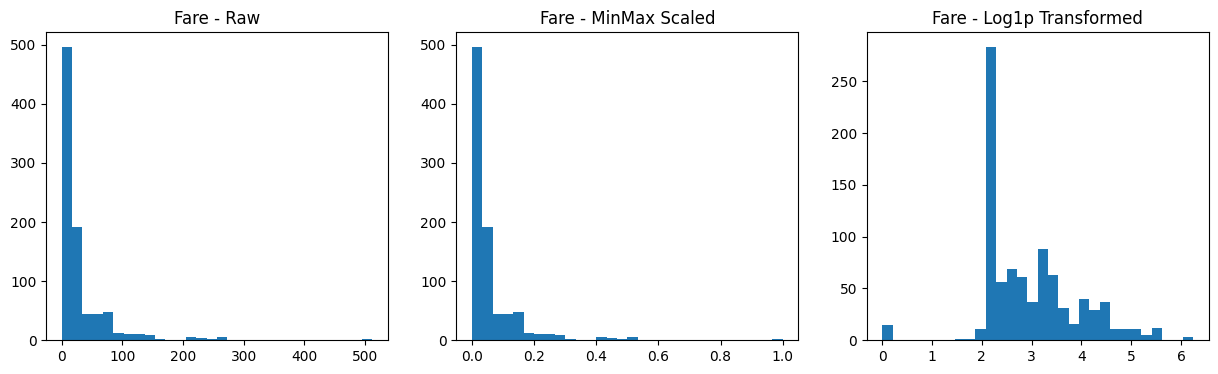

In [ ]:
# Analyze the distributions to answer which step changed the distribution the most
print("\nDistribution comparison:")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(df['Fare'], bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(df_processed['Fare_scaled'], bins=30)
axes[1].set_title('Fare - MinMax Scaled')
axes[2].hist(df_processed['Fare_log'], bins=30)
axes[2].set_title('Fare - Log1p Transformed')
plt.show()

1.) The log transformation of the Fare feature changed the distribution the most.

2.) One-hot encoding produced more features.

Ordinal encoding: assigns a single integer value to each category → only 1 column.

One-hot encoding: creates a separate binary column for each category → number of columns increases with number of categories.

In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nLogistic Regression Accuracy on 75/25 split: {accuracy:.4f}")


Logistic Regression Accuracy on 75/25 split: 0.7758


3.) Logistic regression on processed features achieves about 77–80% accuracy on a 75/25 split.

## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).